# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3162112/11490434 [=======>......................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 13:25 - loss: 0.6972

  21/1875 [..............................] - ETA: 4s - loss: 0.5920   

  51/1875 [..............................] - ETA: 3s - loss: 0.4878

  75/1875 [>.............................] - ETA: 3s - loss: 0.4454

  97/1875 [>.............................] - ETA: 3s - loss: 0.4194

 131/1875 [=>............................] - ETA: 3s - loss: 0.3914

 162/1875 [=>............................] - ETA: 3s - loss: 0.3729

 190/1875 [==>...........................] - ETA: 3s - loss: 0.3595

 223/1875 [==>...........................] - ETA: 3s - loss: 0.3465

 253/1875 [===>..........................] - ETA: 2s - loss: 0.3364

 282/1875 [===>..........................] - ETA: 2s - loss: 0.3280

 317/1875 [====>.........................] - ETA: 2s - loss: 0.3189

 351/1875 [====>.........................] - ETA: 2s - loss: 0.3112

 386/1875 [=====>........................] - ETA: 2s - loss: 0.3041

 421/1875 [=====>........................] - ETA: 2s - loss: 0.2978

 446/1875 [======>.......................] - ETA: 2s - loss: 0.2936

 478/1875 [======>.......................] - ETA: 2s - loss: 0.2887

 509/1875 [=======>......................] - ETA: 2s - loss: 0.2842

 534/1875 [=======>......................] - ETA: 2s - loss: 0.2808

 563/1875 [========>.....................] - ETA: 2s - loss: 0.2772

 594/1875 [========>.....................] - ETA: 2s - loss: 0.2735

 623/1875 [========>.....................] - ETA: 2s - loss: 0.2703

 651/1875 [=========>....................] - ETA: 2s - loss: 0.2673

 678/1875 [=========>....................] - ETA: 2s - loss: 0.2646

 707/1875 [==========>...................] - ETA: 2s - loss: 0.2618

 742/1875 [==========>...................] - ETA: 1s - loss: 0.2586

 775/1875 [===========>..................] - ETA: 1s - loss: 0.2557

 808/1875 [===========>..................] - ETA: 1s - loss: 0.2530

 842/1875 [============>.................] - ETA: 1s - loss: 0.2503

 871/1875 [============>.................] - ETA: 1s - loss: 0.2482

 898/1875 [=============>................] - ETA: 1s - loss: 0.2462

 926/1875 [=============>................] - ETA: 1s - loss: 0.2443

 952/1875 [==============>...............] - ETA: 1s - loss: 0.2425

 979/1875 [==============>...............] - ETA: 1s - loss: 0.2408

1007/1875 [===============>..............] - ETA: 1s - loss: 0.2390

1036/1875 [===============>..............] - ETA: 1s - loss: 0.2373

1064/1875 [================>.............] - ETA: 1s - loss: 0.2356

1092/1875 [================>.............] - ETA: 1s - loss: 0.2340

1120/1875 [================>.............] - ETA: 1s - loss: 0.2325

1144/1875 [=================>............] - ETA: 1s - loss: 0.2312

1172/1875 [=================>............] - ETA: 1s - loss: 0.2298

1201/1875 [==================>...........] - ETA: 1s - loss: 0.2283

1230/1875 [==================>...........] - ETA: 1s - loss: 0.2269

1258/1875 [===================>..........] - ETA: 1s - loss: 0.2255

1287/1875 [===================>..........] - ETA: 1s - loss: 0.2242

1316/1875 [====================>.........] - ETA: 0s - loss: 0.2229

1345/1875 [====================>.........] - ETA: 0s - loss: 0.2216

1374/1875 [====================>.........] - ETA: 0s - loss: 0.2204

1403/1875 [=====================>........] - ETA: 0s - loss: 0.2192

1432/1875 [=====================>........] - ETA: 0s - loss: 0.2180

1460/1875 [======================>.......] - ETA: 0s - loss: 0.2169

1482/1875 [======================>.......] - ETA: 0s - loss: 0.2160

1505/1875 [=======================>......] - ETA: 0s - loss: 0.2152

1528/1875 [=======================>......] - ETA: 0s - loss: 0.2143

1555/1875 [=======================>......] - ETA: 0s - loss: 0.2133

1577/1875 [========================>.....] - ETA: 0s - loss: 0.2125

1602/1875 [========================>.....] - ETA: 0s - loss: 0.2116

1630/1875 [=========================>....] - ETA: 0s - loss: 0.2107

1655/1875 [=========================>....] - ETA: 0s - loss: 0.2098

1680/1875 [=========================>....] - ETA: 0s - loss: 0.2090

1704/1875 [==========================>...] - ETA: 0s - loss: 0.2082

1735/1875 [==========================>...] - ETA: 0s - loss: 0.2072

1762/1875 [===========================>..] - ETA: 0s - loss: 0.2064

1786/1875 [===========================>..] - ETA: 0s - loss: 0.2057

1804/1875 [===========================>..] - ETA: 0s - loss: 0.2051

1821/1875 [============================>.] - ETA: 0s - loss: 0.2046

1846/1875 [============================>.] - ETA: 0s - loss: 0.2039

1867/1875 [============================>.] - ETA: 0s - loss: 0.2033

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2030


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1132

  28/1875 [..............................] - ETA: 3s - loss: 0.1093

  52/1875 [..............................] - ETA: 3s - loss: 0.1095

  75/1875 [>.............................] - ETA: 3s - loss: 0.1096

  99/1875 [>.............................] - ETA: 3s - loss: 0.1097

 121/1875 [>.............................] - ETA: 3s - loss: 0.1097

 149/1875 [=>............................] - ETA: 3s - loss: 0.1098

 173/1875 [=>............................] - ETA: 3s - loss: 0.1099

 195/1875 [==>...........................] - ETA: 3s - loss: 0.1099

 224/1875 [==>...........................] - ETA: 3s - loss: 0.1099

 253/1875 [===>..........................] - ETA: 3s - loss: 0.1099

 281/1875 [===>..........................] - ETA: 3s - loss: 0.1098

 309/1875 [===>..........................] - ETA: 3s - loss: 0.1097

 338/1875 [====>.........................] - ETA: 3s - loss: 0.1096

 364/1875 [====>.........................] - ETA: 2s - loss: 0.1095

 388/1875 [=====>........................] - ETA: 2s - loss: 0.1095

 417/1875 [=====>........................] - ETA: 2s - loss: 0.1094

 445/1875 [======>.......................] - ETA: 2s - loss: 0.1093

 474/1875 [======>.......................] - ETA: 2s - loss: 0.1092

 503/1875 [=======>......................] - ETA: 2s - loss: 0.1091

 532/1875 [=======>......................] - ETA: 2s - loss: 0.1090

 562/1875 [=======>......................] - ETA: 2s - loss: 0.1089

 592/1875 [========>.....................] - ETA: 2s - loss: 0.1089

 622/1875 [========>.....................] - ETA: 2s - loss: 0.1088

 644/1875 [=========>....................] - ETA: 2s - loss: 0.1087

 670/1875 [=========>....................] - ETA: 2s - loss: 0.1086

 694/1875 [==========>...................] - ETA: 2s - loss: 0.1086

 722/1875 [==========>...................] - ETA: 2s - loss: 0.1085

 750/1875 [===========>..................] - ETA: 2s - loss: 0.1084

 777/1875 [===========>..................] - ETA: 2s - loss: 0.1084

 805/1875 [===========>..................] - ETA: 2s - loss: 0.1083

 834/1875 [============>.................] - ETA: 1s - loss: 0.1082

 857/1875 [============>.................] - ETA: 1s - loss: 0.1082

 885/1875 [=============>................] - ETA: 1s - loss: 0.1081

 913/1875 [=============>................] - ETA: 1s - loss: 0.1080

 941/1875 [==============>...............] - ETA: 1s - loss: 0.1080

 971/1875 [==============>...............] - ETA: 1s - loss: 0.1079

 998/1875 [==============>...............] - ETA: 1s - loss: 0.1078

1023/1875 [===============>..............] - ETA: 1s - loss: 0.1078

1048/1875 [===============>..............] - ETA: 1s - loss: 0.1077

1070/1875 [================>.............] - ETA: 1s - loss: 0.1077

1096/1875 [================>.............] - ETA: 1s - loss: 0.1076

1124/1875 [================>.............] - ETA: 1s - loss: 0.1076

1153/1875 [=================>............] - ETA: 1s - loss: 0.1075

1181/1875 [=================>............] - ETA: 1s - loss: 0.1074

1206/1875 [==================>...........] - ETA: 1s - loss: 0.1074

1229/1875 [==================>...........] - ETA: 1s - loss: 0.1073

1258/1875 [===================>..........] - ETA: 1s - loss: 0.1073

1282/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1303/1875 [===================>..........] - ETA: 1s - loss: 0.1072

1333/1875 [====================>.........] - ETA: 1s - loss: 0.1071

1362/1875 [====================>.........] - ETA: 0s - loss: 0.1071

1391/1875 [=====================>........] - ETA: 0s - loss: 0.1070

1413/1875 [=====================>........] - ETA: 0s - loss: 0.1070

1443/1875 [======================>.......] - ETA: 0s - loss: 0.1069

1470/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1499/1875 [======================>.......] - ETA: 0s - loss: 0.1068

1528/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1556/1875 [=======================>......] - ETA: 0s - loss: 0.1067

1585/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1614/1875 [========================>.....] - ETA: 0s - loss: 0.1066

1644/1875 [=========================>....] - ETA: 0s - loss: 0.1065

1673/1875 [=========================>....] - ETA: 0s - loss: 0.1065

1697/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1716/1875 [==========================>...] - ETA: 0s - loss: 0.1064

1740/1875 [==========================>...] - ETA: 0s - loss: 0.1063

1769/1875 [===========================>..] - ETA: 0s - loss: 0.1063

1798/1875 [===========================>..] - ETA: 0s - loss: 0.1062

1827/1875 [============================>.] - ETA: 0s - loss: 0.1062

1855/1875 [============================>.] - ETA: 0s - loss: 0.1061

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1061


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1014

  29/1875 [..............................] - ETA: 3s - loss: 0.1006

  58/1875 [..............................] - ETA: 3s - loss: 0.0997

  87/1875 [>.............................] - ETA: 3s - loss: 0.0994

 116/1875 [>.............................] - ETA: 3s - loss: 0.0992

 144/1875 [=>............................] - ETA: 3s - loss: 0.0991

 169/1875 [=>............................] - ETA: 3s - loss: 0.0991

 193/1875 [==>...........................] - ETA: 3s - loss: 0.0990

 217/1875 [==>...........................] - ETA: 3s - loss: 0.0989

 246/1875 [==>...........................] - ETA: 3s - loss: 0.0989

 269/1875 [===>..........................] - ETA: 3s - loss: 0.0988

 299/1875 [===>..........................] - ETA: 2s - loss: 0.0988

 329/1875 [====>.........................] - ETA: 2s - loss: 0.0988

 358/1875 [====>.........................] - ETA: 2s - loss: 0.0988

 389/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 419/1875 [=====>........................] - ETA: 2s - loss: 0.0987

 449/1875 [======>.......................] - ETA: 2s - loss: 0.0987

 478/1875 [======>.......................] - ETA: 2s - loss: 0.0987

 507/1875 [=======>......................] - ETA: 2s - loss: 0.0987

 536/1875 [=======>......................] - ETA: 2s - loss: 0.0987

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 595/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 624/1875 [========>.....................] - ETA: 2s - loss: 0.0986

 653/1875 [=========>....................] - ETA: 2s - loss: 0.0986

 683/1875 [=========>....................] - ETA: 2s - loss: 0.0985

 711/1875 [==========>...................] - ETA: 2s - loss: 0.0985

 740/1875 [==========>...................] - ETA: 2s - loss: 0.0985

 768/1875 [===========>..................] - ETA: 1s - loss: 0.0985

 798/1875 [===========>..................] - ETA: 1s - loss: 0.0984

 827/1875 [============>.................] - ETA: 1s - loss: 0.0984

 857/1875 [============>.................] - ETA: 1s - loss: 0.0984

 886/1875 [=============>................] - ETA: 1s - loss: 0.0984

 915/1875 [=============>................] - ETA: 1s - loss: 0.0984

 944/1875 [==============>...............] - ETA: 1s - loss: 0.0983

 973/1875 [==============>...............] - ETA: 1s - loss: 0.0983

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1029/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1085/1875 [================>.............] - ETA: 1s - loss: 0.0983

1108/1875 [================>.............] - ETA: 1s - loss: 0.0982

1136/1875 [=================>............] - ETA: 1s - loss: 0.0982

1165/1875 [=================>............] - ETA: 1s - loss: 0.0982

1195/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1219/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1247/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1275/1875 [===================>..........] - ETA: 1s - loss: 0.0982

1304/1875 [===================>..........] - ETA: 1s - loss: 0.0982

1333/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1362/1875 [====================>.........] - ETA: 0s - loss: 0.0981

1390/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1419/1875 [=====================>........] - ETA: 0s - loss: 0.0981

1447/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1476/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1532/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1560/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0980

1646/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1675/1875 [=========================>....] - ETA: 0s - loss: 0.0980

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1732/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1817/1875 [============================>.] - ETA: 0s - loss: 0.0980

1845/1875 [============================>.] - ETA: 0s - loss: 0.0979

1873/1875 [============================>.] - ETA: 0s - loss: 0.0979

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0979


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0958

  28/1875 [..............................] - ETA: 3s - loss: 0.0958

  56/1875 [..............................] - ETA: 3s - loss: 0.0960

  84/1875 [>.............................] - ETA: 3s - loss: 0.0959

 111/1875 [>.............................] - ETA: 3s - loss: 0.0959

 140/1875 [=>............................] - ETA: 3s - loss: 0.0959

 166/1875 [=>............................] - ETA: 3s - loss: 0.0959

 195/1875 [==>...........................] - ETA: 3s - loss: 0.0959

 225/1875 [==>...........................] - ETA: 2s - loss: 0.0959

 254/1875 [===>..........................] - ETA: 2s - loss: 0.0959

 283/1875 [===>..........................] - ETA: 2s - loss: 0.0959

 312/1875 [===>..........................] - ETA: 2s - loss: 0.0959

 341/1875 [====>.........................] - ETA: 2s - loss: 0.0959

 370/1875 [====>.........................] - ETA: 2s - loss: 0.0959

 399/1875 [=====>........................] - ETA: 2s - loss: 0.0959

 428/1875 [=====>........................] - ETA: 2s - loss: 0.0959

 457/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 487/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 515/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 543/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 571/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 598/1875 [========>.....................] - ETA: 2s - loss: 0.0959

 626/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 654/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 683/1875 [=========>....................] - ETA: 2s - loss: 0.0959

 711/1875 [==========>...................] - ETA: 2s - loss: 0.0959

 738/1875 [==========>...................] - ETA: 2s - loss: 0.0959

 765/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 789/1875 [===========>..................] - ETA: 1s - loss: 0.0959

 817/1875 [============>.................] - ETA: 1s - loss: 0.0959

 845/1875 [============>.................] - ETA: 1s - loss: 0.0959

 873/1875 [============>.................] - ETA: 1s - loss: 0.0959

 900/1875 [=============>................] - ETA: 1s - loss: 0.0959

 928/1875 [=============>................] - ETA: 1s - loss: 0.0959

 955/1875 [==============>...............] - ETA: 1s - loss: 0.0959

 982/1875 [==============>...............] - ETA: 1s - loss: 0.0959

1009/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1037/1875 [===============>..............] - ETA: 1s - loss: 0.0959

1065/1875 [================>.............] - ETA: 1s - loss: 0.0959

1093/1875 [================>.............] - ETA: 1s - loss: 0.0959

1120/1875 [================>.............] - ETA: 1s - loss: 0.0959

1148/1875 [=================>............] - ETA: 1s - loss: 0.0960

1176/1875 [=================>............] - ETA: 1s - loss: 0.0960

1205/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1234/1875 [==================>...........] - ETA: 1s - loss: 0.0960

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1290/1875 [===================>..........] - ETA: 1s - loss: 0.0960

1320/1875 [====================>.........] - ETA: 1s - loss: 0.0960

1348/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1371/1875 [====================>.........] - ETA: 0s - loss: 0.0960

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1421/1875 [=====================>........] - ETA: 0s - loss: 0.0960

1449/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1478/1875 [======================>.......] - ETA: 0s - loss: 0.0960

1507/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1536/1875 [=======================>......] - ETA: 0s - loss: 0.0960

1566/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0960

1625/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0960

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0960

1771/1875 [===========================>..] - ETA: 0s - loss: 0.0960

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0959

1828/1875 [============================>.] - ETA: 0s - loss: 0.0959

1857/1875 [============================>.] - ETA: 0s - loss: 0.0959

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0959


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0988

  30/1875 [..............................] - ETA: 3s - loss: 0.0936

  59/1875 [..............................] - ETA: 3s - loss: 0.0942

  88/1875 [>.............................] - ETA: 3s - loss: 0.0946

 115/1875 [>.............................] - ETA: 3s - loss: 0.0948

 143/1875 [=>............................] - ETA: 3s - loss: 0.0948

 172/1875 [=>............................] - ETA: 3s - loss: 0.0949

 200/1875 [==>...........................] - ETA: 2s - loss: 0.0949

 229/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 245/1875 [==>...........................] - ETA: 3s - loss: 0.0950

 266/1875 [===>..........................] - ETA: 3s - loss: 0.0950

 293/1875 [===>..........................] - ETA: 3s - loss: 0.0950

 318/1875 [====>.........................] - ETA: 3s - loss: 0.0950

 341/1875 [====>.........................] - ETA: 3s - loss: 0.0950

 364/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 387/1875 [=====>........................] - ETA: 2s - loss: 0.0950

 416/1875 [=====>........................] - ETA: 2s - loss: 0.0951

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0951

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0951

 495/1875 [======>.......................] - ETA: 2s - loss: 0.0951

 523/1875 [=======>......................] - ETA: 2s - loss: 0.0951

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0951

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 615/1875 [========>.....................] - ETA: 2s - loss: 0.0951

 643/1875 [=========>....................] - ETA: 2s - loss: 0.0951

 668/1875 [=========>....................] - ETA: 2s - loss: 0.0951

 696/1875 [==========>...................] - ETA: 2s - loss: 0.0951

 721/1875 [==========>...................] - ETA: 2s - loss: 0.0952

 743/1875 [==========>...................] - ETA: 2s - loss: 0.0952

 767/1875 [===========>..................] - ETA: 2s - loss: 0.0952

 787/1875 [===========>..................] - ETA: 2s - loss: 0.0952

 810/1875 [===========>..................] - ETA: 2s - loss: 0.0952

 838/1875 [============>.................] - ETA: 2s - loss: 0.0952

 860/1875 [============>.................] - ETA: 2s - loss: 0.0952

 882/1875 [=============>................] - ETA: 2s - loss: 0.0952

 908/1875 [=============>................] - ETA: 1s - loss: 0.0952

 930/1875 [=============>................] - ETA: 1s - loss: 0.0952

 957/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1014/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1041/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1070/1875 [================>.............] - ETA: 1s - loss: 0.0952

1100/1875 [================>.............] - ETA: 1s - loss: 0.0952

1129/1875 [=================>............] - ETA: 1s - loss: 0.0952

1156/1875 [=================>............] - ETA: 1s - loss: 0.0952

1181/1875 [=================>............] - ETA: 1s - loss: 0.0952

1209/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0952

1261/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1290/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1318/1875 [====================>.........] - ETA: 1s - loss: 0.0952

1345/1875 [====================>.........] - ETA: 1s - loss: 0.0952

1371/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1396/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1423/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1451/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1508/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1536/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1564/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1651/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1708/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1792/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1819/1875 [============================>.] - ETA: 0s - loss: 0.0952

1846/1875 [============================>.] - ETA: 0s - loss: 0.0952

1874/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

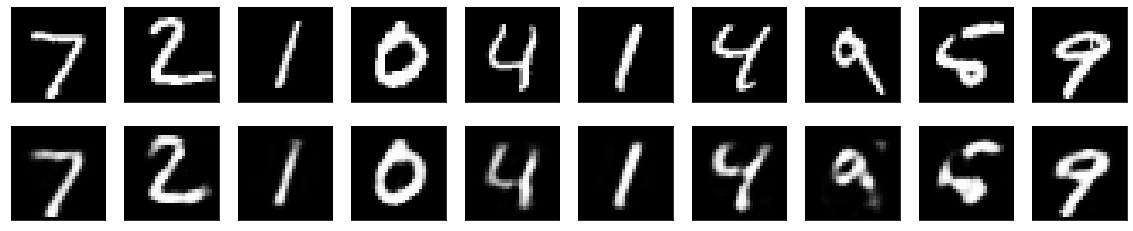

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
